# Modeling listing prices

In this notebook, we will focus on modeling occupancy rate for airbnb listings. Based on our EDA, occupancy rate poses more chanllenges for modeling purposes (compared to price) and because of this, we will just focus on models that had a better performance.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# xgboost
import xgboost as xgb

#Bayesian optimizer
!pip install scikit-optimize
from skopt import BayesSearchCV

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.5 MB/s eta 0:00:00 0:00:01


In [2]:
#df = pd.read_csv('./../data/austin_listings_clean.csv').drop(columns=['occupancy_rate'])
df = pd.read_csv('https://raw.githubusercontent.com/malfii/airbnb_investment/main/data/austin_listings_clean.csv').drop(columns=['price'])
df.head(5)

,bedrooms,beds,bath,zipcode,host_is_superhost,review_scores_rating,time_quarter,has_pool,is_petfriendly,has_workspace,has_freeparking,has_gym,home_price_aprx,occupancy_rate
0,1,2,1.0,78702,1,4.84,Q4,0,0,0,0,0,613000,0.700000
1,0,1,1.0,78704,0,4.97,Q4,0,0,1,0,0,802000,0.700000
2,1,2,1.0,78704,1,4.97,Q4,0,0,1,1,0,802000,0.584160
3,1,1,1.0,78741,0,4.56,Q4,0,1,0,0,0,397000,0.100850
4,2,2,2.0,78702,1,5.00,Q4,0,0,1,0,0,613000,0.216998


## Correlation between different features

<ipython-input-4-d1e0bf25aad0>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = round(df.corr(), 2)


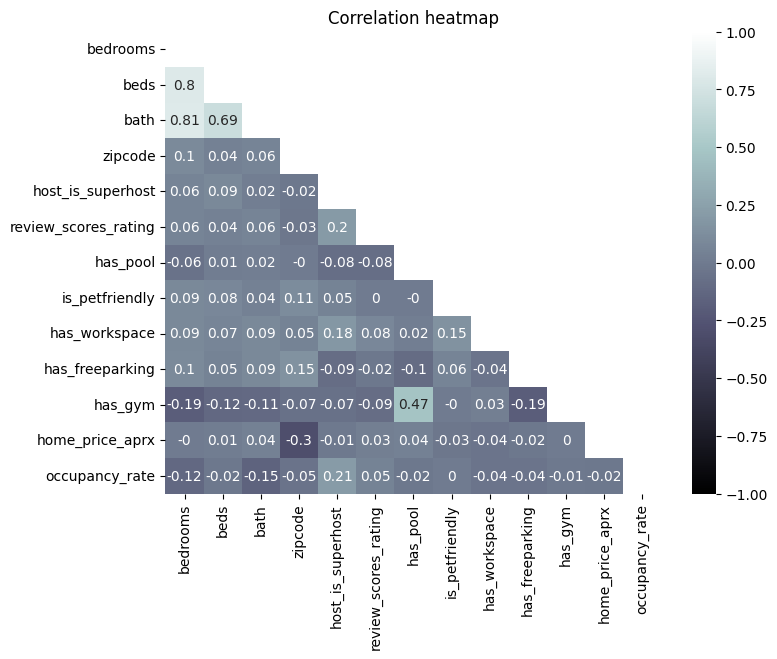

In [4]:
# plot the correlation matrix heatmap
plt.figure(figsize=(8, 6))
corr = round(df.corr(), 2)
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, annot=True, cmap='bone',
            vmin = -1, vmax=1)
plt.title('Correlation heatmap');

As expected from our EDA, there are not that many features with a high correlation to occupancy rate. According to the correlation map, we can say the most import feature that is related to occupancy rate is whether the host is experienced or not (the term superhost is used in airbnb terminology).

## Null model

Our null model in this case is the average occupancy rate for the lisitngs observed in our training datat.

In [7]:
# create a dataframe for the null model
X = df.drop(columns=['occupancy_rate'])
y = df['occupancy_rate']
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
pred = y_train.mean()
print(f'predicted occupancy rate for the null model: {round(pred, 2)}')

predicted occupancy rate for the null model: 0.25


In [9]:
preds_train = pred*np.ones(len(y_train))
preds_test = pred*np.ones(len(y_test))
print(f'Train data R2 = {r2_score(y_train, preds_train)}')
print(f'Train data MAE = {round(mean_absolute_error(y_train, preds_train), 2)}')
print(f'Test data R2 = {r2_score(y_test, preds_test)}')
print(f'Test data MAE = {round(mean_absolute_error(y_test, preds_test), 2)}')

Train data R2 = 0.0
Train data MAE = 0.21
Test data R2 = -1.7305167333336868e-05
Test data MAE = 0.21


__Highlights__:
- Null model predicts an average occupancy rate of 0.25 for airbnb housing in Austin.

##Linear regression with polynomial features (Ridge)

For linear modeling, we will use all features that are available for us with the corresponding quadratic interaction features so that our model takes advantage of all features and interaction terms. In order to prevent high variance, we will regularize the model by using Ridge regularization.

In [12]:
X = df.drop(columns=['occupancy_rate'])
y = df['occupancy_rate']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_zip', ohe, ['zipcode']),
        ('ohe_time', ohe, ['time_quarter'])
    ], remainder='passthrough')
# create pipeline
ridge_poly_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('poly', PolynomialFeatures(degree=2, interaction_only=False)),
    ('ridge', Ridge())]
)

# gridsearch object
gs_ridge_poly_pipeline = GridSearchCV(ridge_poly_pipeline,
                                     param_grid={'ridge__alpha': np.logspace(0, 4, 50)},
                                      verbose = 2,
                                      cv =5,
                                      n_jobs=-1
                                     )

# fit the model
gs_ridge_poly_pipeline.fit(X_train, y_train)

# predict data
preds_train = gs_ridge_poly_pipeline.predict(X_train)
preds_test = gs_ridge_poly_pipeline.predict(X_test)

# best alpha
print(gs_ridge_poly_pipeline.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'ridge__alpha': 1048.1131341546852}


In [13]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE = {round(mean_absolute_error(y_train, preds_train), 2)}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE = {round(mean_absolute_error(y_test, preds_test), 2)}')

Train data R2 = 0.1711
Train data MAE = 0.18
Test data R2 = 0.1291
Test data MAE = 0.19


The linear model is only able to capture 0.13 of the variability in data and results in a very poor prediction. We will skip doing any error analysis due to the very poor performance of the model.

__Highlights:__
- Linear models (with quadratic interaction terms and regularization) show a very poor performance to predict occupancy rate (R2 = 0.13).

## XGBoost regressor

XGBoost showed the best performance in predicting the house price. Let us see how it performs on the occupancy rate data.

In [24]:
df_xgb = df.copy()
# convert the type into category
df_xgb[['zipcode', 'time_quarter']] = df_xgb[['zipcode', 'time_quarter']].astype('category')

X = df_xgb.drop(columns=['occupancy_rate'])
y = df_xgb['occupancy_rate']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)


# create the xgb instance
xgb_reg = xgb.XGBRegressor(enable_categorical=True)

param_space = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2, 0.4, 0.6], # [0.1, 0.2, 0.4, 0.6, 0.8]
    'max_depth': [5, 8, 10], # this has significant effects on R2
    'subsample': [0.5, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0001, 0.001, 0.01, 0.1, 1], #[ 0.001, 0.01, 0.1, 1]
    'gamma': [0.05, 0.1, 1], # [0.1, 1, 3]
    'eta': [0.2, 0.5, 0.7], #[0.2, 0.5]
    'min_child_weight': [3, 5] # [1, 3, 5]

}
bayes_xgb_reg = BayesSearchCV(xgb_reg,
                         param_space,
                         cv=5,
                         verbose=0,
                         n_iter=100, # 50
                         scoring='neg_mean_absolute_error',
                         random_state=42)
bayes_xgb_reg.fit(X_train, y_train)


# predict data
preds_train = bayes_xgb_reg.predict(X_train)
preds_test = bayes_xgb_reg.predict(X_test)

# parameters for the best estimator
print('=============')
for i in bayes_xgb_reg.best_params_.items():
  print(i[0], i[1])
print('=============')
print('Best score (neg mae):')
print(bayes_xgb_reg.best_score_)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

colsample_bytree 1.0
eta 0.7
gamma 0.05
learning_rate 0.2
max_depth 10
min_child_weight 3
n_estimators 150
reg_alpha 0.0001
subsample 0.9
Best score (neg mae):
-0.13870773814538023


In [25]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE = {round(mean_absolute_error(y_train, preds_train), 2)}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE = {round(mean_absolute_error(y_test, preds_test), 2)}')

Train data R2 = 0.6302
Train data MAE = 0.11
Test data R2 = 0.4535
Test data MAE = 0.14


XGBoost improves our model performance by increasing the R2 to 0.45. As common in tree based algorithms, our model shows overfitting but still the performance is noticably good, given the fact that the occupancy rate has not shown strong correlation to any of the features during our EDA.

Let us look at how our model error is distributed.

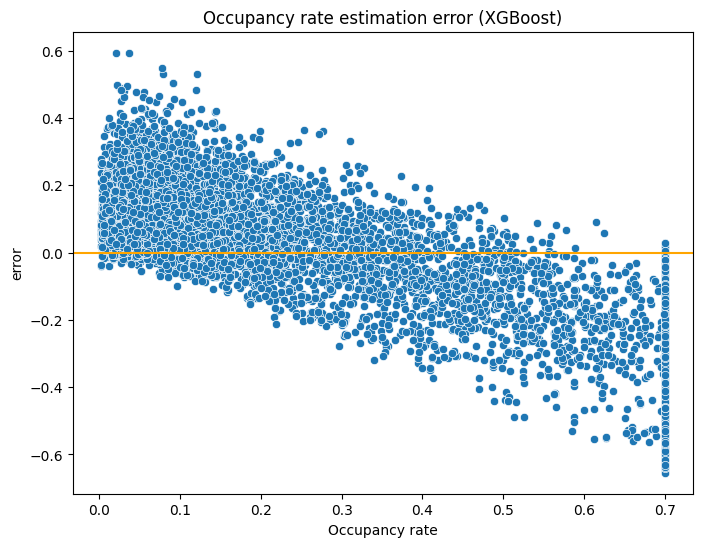

In [31]:
error = preds_test - y_test
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=error)
plt.xlabel('Occupancy rate')
plt.ylabel('error')
plt.title('Occupancy rate estimation error (XGBoost)')
plt.axhline(0, color='orange');

We can see that the model tends to overestimate the occupancy rate values at the smaller occupancy rates while it underestimates the higher occupancy rates.

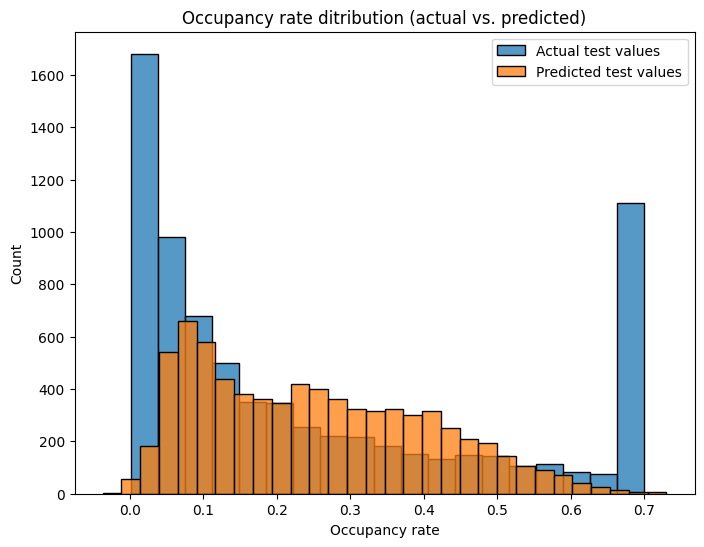

In [33]:
plt.figure(figsize=(8, 6))

sns.histplot(y_test, label='Actual test values')
sns.histplot(preds_test, label='Predicted test values')
plt.xlabel('Occupancy rate')
plt.ylabel('Count')
plt.legend()
plt.title('Occupancy rate ditribution (actual vs. predicted)');

Plotting the occupancy rate distribution in the test data and the predicted distribution shows a similar observation. Our model is not able to properly model the high and low occupancy rates. One thing that might help us here is to use mean squared error (instead of mean asbolute error) and scaling the data (with a scaling factor of 1000) so that the model puts more weight into predicting the higher values of occupancy rate.

In [55]:
df_xgb = df.copy()
# convert the type into category
df_xgb[['zipcode', 'time_quarter']] = df_xgb[['zipcode', 'time_quarter']].astype('category')

X = df_xgb.drop(columns=['occupancy_rate'])
y = df_xgb['occupancy_rate'] * 1000
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)


# create the xgb instance
xgb_reg = xgb.XGBRegressor(enable_categorical=True)

param_space = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2, 0.4, 0.6], # [0.1, 0.2, 0.4, 0.6, 0.8]
    'max_depth': [5, 8, 10], # this has significant effects on R2
    'subsample': [0.5, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0001, 0.001, 0.01, 0.1, 1], #[ 0.001, 0.01, 0.1, 1]
    'gamma': [0.05, 0.1, 1], # [0.1, 1, 3]
    'eta': [0.2, 0.5, 0.7], #[0.2, 0.5]
    'min_child_weight': [3, 5] # [1, 3, 5]

}
bayes_xgb_reg = BayesSearchCV(xgb_reg,
                         param_space,
                         cv=5,
                         verbose=0,
                         n_iter=50, # 50
                         scoring='neg_mean_squared_error',
                         random_state=42)
bayes_xgb_reg.fit(X_train, y_train)


# predict data
preds_train = bayes_xgb_reg.predict(X_train)/1000
preds_test = bayes_xgb_reg.predict(X_test)/1000
y_train = y_train/1000
y_test = y_test/1000

# parameters for the best estimator
print('=============')
for i in bayes_xgb_reg.best_params_.items():
  print(i[0], i[1])
print('=============')
print('Best score (neg mse):')
print(bayes_xgb_reg.best_score_)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

colsample_bytree 1.0
eta 0.5
gamma 0.1
learning_rate 0.1
max_depth 10
min_child_weight 3
n_estimators 100
reg_alpha 0.001
subsample 1.0
Best score (neg mse):
-30613.29766888381


In [56]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE = {round(mean_absolute_error(y_train, preds_train), 2)}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE = {round(mean_absolute_error(y_test, preds_test), 2)}')

Train data R2 = 0.7269
Train data MAE = 0.09
Test data R2 = 0.4856
Test data MAE = 0.13


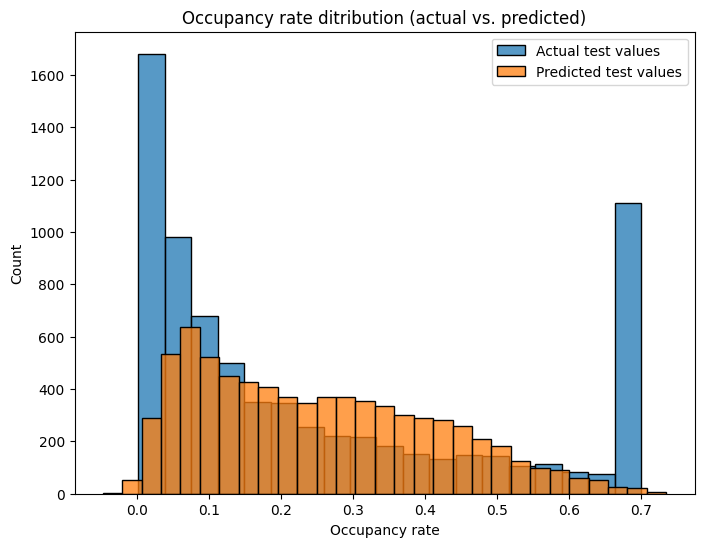

In [57]:
plt.figure(figsize=(8, 6))

sns.histplot(y_test, label='Actual test values')
sns.histplot(preds_test, label='Predicted test values')
plt.xlabel('Occupancy rate')
plt.ylabel('Count')
plt.legend()
plt.title('Occupancy rate ditribution (actual vs. predicted)');

Looking at the plot and scores for this new model, we were able to improve model performance by changing the error metrics and tranforming our data. Other approaches like oversampling the high occupancy values were tried as well but they did not improve our model performance.


__Highlights:__
- XGBoost shows the best performance in predicting the occupancy rate (R2 = 0.49).

## Key takeaways

- Features collected in this work do not show that much correlation with occupancy rate, hence it makes it extremely tricky to model occupancy rate.
- Linear regression models performed very poorly in predicting the occupancy rate.
- XGBoost shows the best performance in predicting the occupancy rate but still struggles with very low or very high occupancy rates.
- Using different metrics for error analysis in XGBoost and giving more weight to the higher occupancy rates helps the model improve predictions for higher occupancy rates.